In [1]:
from config import config
import pytesseract

Device:cuda


In [2]:
def load_model():
    pytesseract.pytesseract.tesseract_cmd = config.TESSERACT_LINK
load_model()

**Input**

In [3]:

book_link = "./datasets/book_test/mucluc_book_KTvaDBCLPM-trang1-3.pdf"
size_sumary = 20
# Tóm tắt page - True | format % - False
is_page = False
link_output_page = "./output/page_image"

In [4]:
from src.ocr.pdf_to_img import pdf_to_images

In [5]:
pages_np = pdf_to_images(book_link, link_output_page)

Convertmucluc_book_KTvaDBCLPM-trang1-3
Conversion completed successfully!


In [6]:
from src.ocr.pdf_to_img import pdf_to_image_np
pages_np = pdf_to_image_np(book_link)
len_pages = len(pages_np)
print(f"len_pages:{len_pages}")

Start Convert
len_pages:3


In [7]:
import re
from src.VietnameseOcrCorrection.config import LINK_MODEL_SEQ2SEQ
from src.VietnameseOcrCorrection.tool.predictor import Predictor
from config.config_text import VI_TEXT_LOWERCASE, VI_TEXT_UPPERCASE


def clear_text(text):
    SAVE_KEY_REGEX_PATTERN = re.compile(
        r"[^a-zA-Z0-9\s\t\.\,{}()\-/{}]".format(
            re.escape(VI_TEXT_LOWERCASE),
            re.escape(VI_TEXT_UPPERCASE),
        )
    )
    text = SAVE_KEY_REGEX_PATTERN.sub(" ", text)
    text = re.sub(r"\t|\n", " ", text)
    text = re.sub(r"\.{2,}", "", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r" \.", ".", text)
    text = text.rstrip()
    return text
    # text = re.sub(r"\t|\n|\s{2,}|\.{2,}", " ", text)
    # text = re.sub(r" \.", ".", text).strip()
    # return text


def correct_text(text):
    model_predictor = Predictor(
        device="cpu",
        model_type="seq2seq",
        weight_path=LINK_MODEL_SEQ2SEQ,
    )
    outs = model_predictor.predict(text.strip(), NGRAM=6)
    return outs

In [8]:
from config.config_text import CHAPTER_KEYWORD_NUMBER


def is_table_of_contents(text, chapter_lv1):
    text = text.lower()
    lines = text.split("\n")
    # Kiểm tra xem có ít nhất một dòng bắt đầu bằng số hoặc từ khóa
    for line in lines:
        if line.strip().startswith(chapter_lv1):
            return True
    # Kiểm tra xem có ít nhất một dòng chứa các tiêu đề có độ sâu lồng nhau không
    for i in range(len(lines)):
        if lines[i].strip().startswith(chapter_lv1):
            for j in range(i + 1, min(i + 4, len(lines))):
                if lines[j].strip().startswith(tuple(CHAPTER_KEYWORD_NUMBER)):
                    return True
    return False

In [11]:
import cv2
link_box ="./output/line/line_0_0.jpg"
link_page = "./output/page_image/mucluc_book_KTvaDBCLPM-trang1-3/page_0.png"
image_test = cv2.imread(link_box)


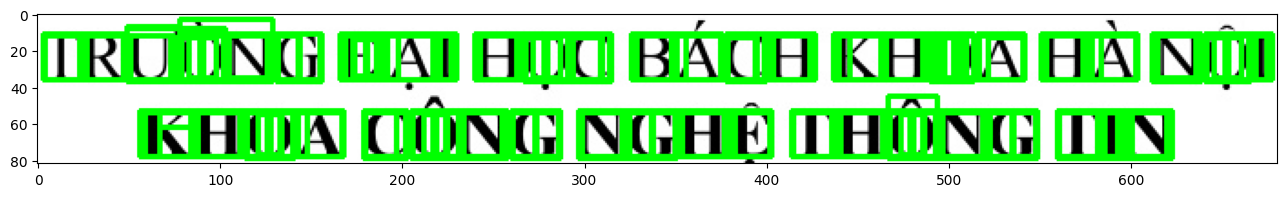

In [12]:
from matplotlib import pyplot as plt
from src.ocr.ocr_image import detect_text_area
image_hulls = image_test.copy()
hulls = detect_text_area(image_hulls)
# Vẽ hình chữ nhật quanh các vùng chữ
for hull in hulls:
    x, y, w, h = cv2.boundingRect(hull)
    cv2.rectangle(image_hulls, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Lưu ảnh có vùng chữ được vẽ
# cv2.imwrite(r'D:\Product\text_summarizer\datasets\data_test\output.jpg', image_1)
plt.rcParams['figure.figsize'] = (16, 16)
plt.imshow(image_hulls)

In [ ]:
# Chia ảnh thành các dòng chữ
lines_page = []
line_hull = []

for hull in hulls:
    x, y, w, h = cv2.boundingRect(hull)

    # Kiểm tra xem có phải dòng chữ đầu tiên không
    if line_hull:
        # Tính toán khoảng cách theo trục y giữa dòng chữ hiện tại và dòng chữ trước đó
        distance_y = y - line_hull[-1][1]
        print(f"line: {x, y, w, h}", f"next line: {line_hull[-1]}", distance_y)
        # Kiểm tra nếu khoảng cách lớn hơn chiều cao của dòng chữ hiện tại
        if distance_y > h:
            # Nếu là đúng, thêm dòng chữ hiện tại vào danh sách các dòng đã tìm được
            lines_page.append(line_hull)

            # Khởi tạo một dòng chữ mới
            line_hull = []

    # Thêm hình chữ nhật vào dòng chữ hiện tại
    line_hull.append((x, y, x + w, y + h))

# Thêm dòng chữ cuối cùng vào danh sách nếu cần
if line_hull:
    lines_page.append(line_hull)

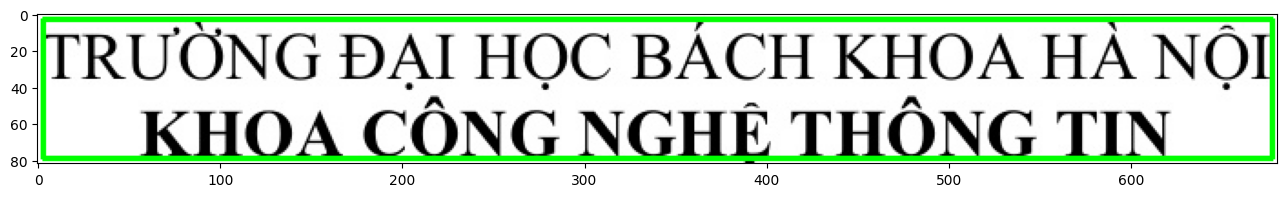

In [16]:
lines_rects_page = []
image_pp = image_test.copy()
for line in lines_page:
    x_min = min(rect[0] for rect in line)
    y_min = min(rect[1] for rect in line)
    x_max = max(rect[2] for rect in line)
    y_max = max(rect[3] for rect in line)
    lines_rects_page.append((x_min, y_min, x_max, y_max))
    # Vẽ hình chữ nhật lớn xung quanh tất cả các hình chữ nhật con
    cv2.rectangle(image_pp, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
plt.rcParams["figure.figsize"] = (16, 16)
plt.imshow(image_pp)

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_text_area_xx(image):
    """
    Detects text areas in the given image using the MSER algorithm and merges boxes on the same line.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        list: A list of merged bounding boxes representing text areas.
    """

    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Use MSER to detect regions containing text
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(gray)

    # Filter out small regions and get their convex hulls
    regions = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
    regions = [h for h in regions if cv2.contourArea(h) > 100]

    # Sort regions from top to bottom based on the bounding box's y-coordinate
    regions.sort(key=lambda x: cv2.boundingRect(x)[1])

    # Convert regions to bounding boxes
    bboxes = [cv2.boundingRect(region) for region in regions]

    # Merge bounding boxes that are on the same line
    merged_bboxes = []
    current_bbox = bboxes[0]

    for bbox in bboxes[1:]:
        # If the bounding boxes are on the same line (adjust the threshold as needed)
        if abs(bbox[1] - current_bbox[1]) < 10:
            # Merge the boxes
            x = min(current_bbox[0], bbox[0])
            y = min(current_bbox[1], bbox[1])
            w = max(current_bbox[0] + current_bbox[2], bbox[0] + bbox[2]) - x
            h = max(current_bbox[1] + current_bbox[3], bbox[1] + bbox[3]) - y
            current_bbox = (x, y, w, h)
        else:
            # Add the current bounding box to the list and start a new one
            merged_bboxes.append(current_bbox)
            current_bbox = bbox

    # Add the last bounding box
    merged_bboxes.append(current_bbox)

    return merged_bboxes

In [41]:
# Detect text areas
image_xx = image_test.copy()
merged_bboxes = detect_text_area_xx(image_xx)
print(merged_bboxes)

[(3, 3, 675, 34), (79, 13, 582, 23), (56, 45, 567, 34), (67, 55, 534, 23)]


In [42]:
def merge_boxes(boxes):
    # Sắp xếp các hình chữ nhật theo tọa độ x của góc trái trên
    boxes = sorted(boxes, key=lambda x: x[0])
    merged_boxes = []

    for box in boxes:
        x1, y1, w1, h1 = box
        merged = False

        for merged_box in merged_boxes:
            x2, y2, w2, h2 = merged_box

            # Kiểm tra xem box có nằm hoàn toàn bên trong merged_box không
            if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                merged = True
                break

            # Kiểm tra xem merged_box có nằm hoàn toàn bên trong box không
            if x2 >= x1 and y2 >= y1 and x2 + w2 <= x1 + w1 and y2 + h2 <= y1 + h1:
                merged_boxes.remove(merged_box)
                merged_box = box
                merged_boxes.append(merged_box)
                merged = True
                break

        if not merged:
            merged_boxes.append(box)

    return merged_boxes

# Gộp các hình chữ nhật
merged_bboxes_2 = merge_boxes(merged_bboxes)
print(merged_bboxes_2)

[(3, 3, 675, 34), (56, 45, 567, 34)]


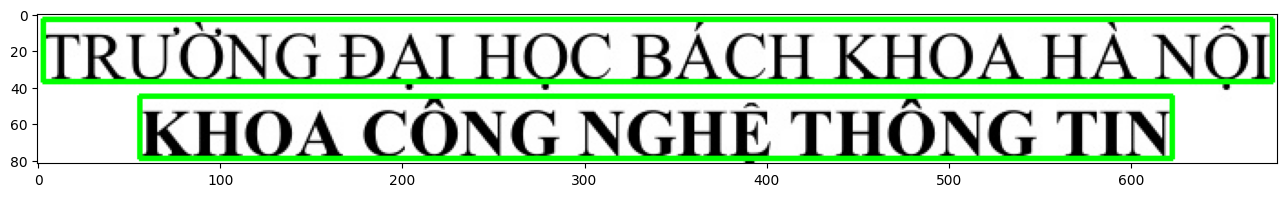

In [43]:
# Draw detected regions on the image_xx for visualization
for bbox in merged_bboxes_2:
    x, y, w, h = bbox
    cv2.rectangle(image_xx, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.rcParams["figure.figsize"] = (16, 16)
plt.imshow(image_xx)

(524, 179, 1213, 269)
(841, 271, 907, 311)
(702, 368, 1035, 420)
(599, 797, 1137, 854)
(485, 902, 1252, 967)
(463, 1010, 1275, 1075)
(284, 2052, 1407, 2068)


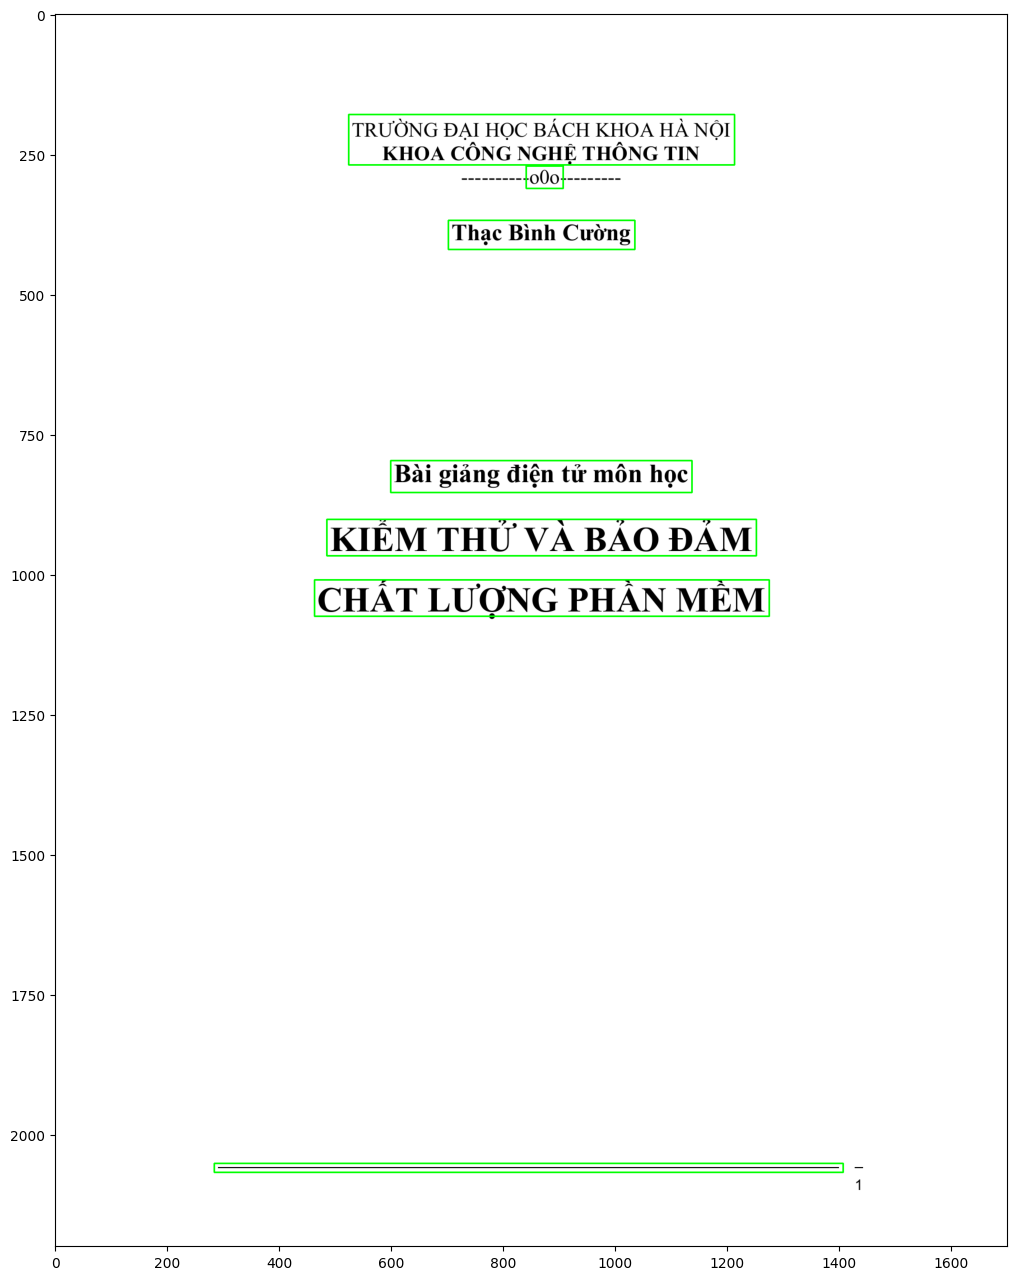

In [26]:
from src.ocr.ocr_image import detect_line_word

image_lines = image_test.copy()
lines_rects = detect_line_word(image_lines, is_menu=True)
for lines_rect in lines_rects:
    print(lines_rect)
    x_min, y_min, x_max, y_max = lines_rect
    cv2.rectangle(image_lines, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
plt.rcParams["figure.figsize"] = (16, 16)
plt.imshow(image_lines)

In [ ]:
# Extract table of contents from pages
from config.config_text import CHAPTER_LV1
from src.ocr.ocr_image import crop_box, detect_line_word
from tools.save_step import save_crop_image


def extract_table_of_contents(list_page):
    # Kết hợp danh sách LV1_KEYWORDS và CHAPTER_KEYWORD

    last_toc_page, table_of_contents = None, []
    for i, page in enumerate(list_page):
        lines_rects = detect_line_word(page, is_menu=True)
        is_menu = 0
        page_content = []

        for j, line in enumerate(lines_rects):
            save_crop_image(page, line, f"line_{i}_{j}")
            roi = crop_box(page, line)
            text_line = pytesseract.image_to_string(roi, lang="vie")

            if len(text_line) != 0:
                print(f"text_{i}_{j}: {text_line}")
                text_line = clear_text(text_line)
                try:
                    text_line = correct_text(text_line)
                except:
                    print(f"line {i}_{j}: False")
                    continue
                print(f"line {i}_{j}: {text_line}")
                text_line = text_line.rstrip(".")

                if is_table_of_contents(text_line, CHAPTER_LV1):
                    is_menu += 1

                page_content.append(text_line)

        if is_menu == 0 or is_menu < (len(lines_rects) - 5):
            continue
        else:
            last_toc_page = i + 1
            table_of_contents += page_content

    return last_toc_page, table_of_contents

In [ ]:
extract_table_of_contents(pages_np)